In [1]:
import numpy as np
import json
import io
import os
import sys
import pickle
import math
import random

from sklearn.metrics import mean_absolute_error

from pymoo.core.problem import ElementwiseProblem
from non_iid_generator.customDataset import CustomDataset

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA

from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling, IntegerRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

import matplotlib.pyplot as plt

from traceback import print_exc

In [2]:
NO_CLIENTS = 56
NO_GROUPS = 7
NO_CLASSES = 10
ALPHA = "03"

In [3]:
# path = "data/Cifar10_NIID_a05_140c/config.json"
# path = "data/alpha/Cifar10_NIID_20c_a03/config.json"
# path = "projects/define_pretrained_fed_sim_NIID_alpha03/data/config.json"
# path = "data/32_Cifar10_NIID_80c_a03/config.json"
path = f"data/32_Cifar10_NIID_{NO_CLIENTS}c_a{ALPHA}/config.json"
conf = json.loads(open(path, "r").read())
data = [dict(zip(np.array(cli)[:,0], np.array(cli)[:,1])) for cli in conf["Size of samples for labels in clients"]]

main_label_vectors = np.zeros((NO_CLIENTS,NO_CLASSES))
for client_id in range(NO_CLIENTS):
    for class_id in range(NO_CLASSES):
        if class_id in data[client_id].keys():
            main_label_vectors[client_id][class_id] = data[client_id][class_id]

In [4]:
def EMD(Z_i, Z_global):
    magnitude = lambda vector: math.sqrt(sum(pow(element, 2) for element in vector))
    return magnitude(Z_i/magnitude(Z_i) - Z_global/magnitude(Z_global))

def group_distribution(label_vectors, groups):
    group_dist = []
    for gid in range(NO_GROUPS):
        group_vector = label_vectors[groups == gid]
        group_dist.append(np.sum(group_vector, axis = 0))
    return group_dist

def group_max_size(label_vectors, groups):
    group_max = []
    for gid in range(NO_GROUPS):
        group_vector = label_vectors[groups == gid]
        group_max.append(np.amax(np.sum(group_vector, axis = 1)))
    return group_max

def emd_obj(group_dist):
    Z_global = np.sum(group_dist, axis = 0)
    return np.sum([EMD(group, Z_global) for group in group_dist])

def network_diff(networks, groups):
    group_diff = []
    for gid in range(NO_GROUPS):
        group_vector = networks[groups == gid]
        min_val = np.amin(group_vector)
        max_val = np.amax(group_vector)
        group_diff.append(max_val - min_val)
    return group_diff
        

groups = np.repeat(np.arange(7),8)
np.random.shuffle(groups)

group_dist = group_distribution(main_label_vectors, groups)
emd_obj(group_dist)



client = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1000, 0,])
Z_global = np.ones(10, dtype=int) * 1000
EMD(client, Z_global) * 7

8.18594398529271

In [207]:
max_dur = 227.205799 / (2_500_000 / 8 / 1_000_000)
min_dur = 227.205799 / (50_000_000 / 8 / 1_000_000)
max_dur, min_dur

(727.0585568, 36.35292784)

345.35281448

In [208]:
sizes_by_block = []
for block_no in range(7):
    s = os.path.getsize(f"./projects/test/test-1/worker/iter_1_block_{block_no}_model.pth.tar")
    sizes_by_block.append(s/1_000_000)
# sizes_by_block.append(200)
# sizes_by_block.append(200)
# sizes_by_block.append(200)
sizes_by_block

[227.205799,
 227.060071,
 226.930983,
 226.949479,
 208.148775,
 9.623975,
 160.160487]

In [209]:
227 / (2.5/8)

726.4

In [210]:
weak    = 2_500_000 
normal1 = 15_000_000
normal2 = 35_000_000
normal1 = 80_000_000
normal2 = 80_000_000
strong  = 80_000_000

WEAK_NETWORK = np.array([2_500_000])
NORMAL_NETWORK = np.arange(8_000_000, 16_000_000, 1_000_000)
STRONG_NETWORK = np.arange(30_000_000, 50_000_000, 5_000_000)

# networks = np.repeat([weak, normal1, normal2, normal1, normal2, normal1, normal2, strong, strong, strong],8)
# networks = np.repeat([weak, normal1, normal2, normal1, normal2, strong, strong],8)
# networks = np.repeat([
#     weak,
#     normal1,
#     normal1,
#     normal1,
#     normal1,
#     normal1,
#     normal2,
#     normal2,
#     normal2,
#     normal2,
#     normal2,
#     strong,
#     strong,
#     strong],4)
networks = np.repeat([
    random.choice(WEAK_NETWORK),
    random.choice(NORMAL_NETWORK),
    random.choice(NORMAL_NETWORK),
    random.choice(NORMAL_NETWORK),
    random.choice(NORMAL_NETWORK),
    random.choice(NORMAL_NETWORK),
    random.choice(NORMAL_NETWORK),
    random.choice(NORMAL_NETWORK),
    random.choice(NORMAL_NETWORK),
    random.choice(NORMAL_NETWORK),
    random.choice(NORMAL_NETWORK),
    random.choice(STRONG_NETWORK),
    random.choice(STRONG_NETWORK),
    random.choice(STRONG_NETWORK)],4)
np.random.shuffle(networks)
print(networks)
len(networks)

[14000000 15000000 45000000 30000000 15000000 45000000 11000000 15000000
 15000000  9000000 14000000 12000000 45000000 15000000 12000000  9000000
  9000000 15000000 15000000 15000000 30000000 45000000 15000000  2500000
 14000000 45000000  9000000 15000000  9000000 11000000  9000000  2500000
 30000000 15000000 11000000 12000000 15000000 45000000  9000000  2500000
 15000000 15000000  9000000 12000000 15000000 14000000 15000000  9000000
  9000000  2500000 45000000 45000000 30000000  9000000  9000000 11000000]


56

In [211]:
baseline_dict = {}
sorted_network = np.sort(networks).tolist()

for s in np.sort(sizes_by_block):
    baseline_dict[s] = []
    for i in range(8):
        baseline_dict[s].append(sorted_network.pop(0) / 8 / 1_000_000 )

In [212]:
[k/np.amin(v) for k,v in baseline_dict.items()]

[30.79672,
 142.3648773333333,
 151.38092727272726,
 129.67484742857144,
 121.03972213333333,
 121.09870453333333,
 40.39214204444445]

In [5]:
import random

class MyProblem(ElementwiseProblem):

    def __init__(self, main_label_vectors):
        super().__init__(n_var=NO_CLIENTS,
                         n_obj=1,
                        #  n_obj=1 + NO_GROUPS,
                        #  n_obj=0 + NO_GROUPS,
                         n_eq_constr=NO_GROUPS,
                        #  n_ieq_constr=NO_GROUPS,
                         xl=np.ones(NO_CLIENTS) * 0,
                         xu=np.ones(NO_CLIENTS) * (NO_GROUPS),
                        #  xu=np.ones(NO_CLIENTS) * 10,

                         vtype=int)
        self.main_label_vectors = main_label_vectors

    def _evaluate(self, x, out, *args, **kwargs):
        group_dist = group_distribution(self.main_label_vectors, x)
        f1 = emd_obj(group_dist) / 8
        # f2 = random.randint(0, 5)

        try:
            # group_diff = network_diff(networks, x)
            # dif = np.amax(group_max) - np.amin(group_max)

            fed_duration = []
            fed_std = []
            fed_global = []
            for group_id in range(NO_GROUPS):
                model_size = sizes_by_block[group_id]
                group_networks = networks[np.array(x) == group_id]
                bn_bw = np.amin(group_networks)
                dur = model_size / (bn_bw / 8 / 1_000_000)
                fed_duration.append(dur)
                fed_std.append(np.std(group_networks / 50_000_000 ))

                fed_global.append(model_size / (np.amin(baseline_dict[model_size])))

            # # fs = fed_duration
            # fs = [
            #     # np.std(fed_duration) / np.std([max_dur, min_dur]),
            #     # (np.amax(fed_duration) - min_dur) / (max_dur - min_dur),
            #     # (-np.amin(fed_duration) - min_dur) / (max_dur - min_dur)
            #     (np.amax(fed_duration) - np.amin(fed_duration)) / (max_dur - min_dur)
            #     ] + fed_std
            # fs = [np.mean(fed_duration), np.amax(fed_duration)]
            # # print(fs)
            # # f2 = np.amax(fed_duration)

            # preds = {}
            # maes = []
            # for group_id in range(NO_GROUPS):
            #     model_size = sizes_by_block[group_id]
            #     group_networks = networks[np.array(x) == group_id]
            #     preds[model_size] = np.sort(group_networks) / 1_000_000
            #     mae = mean_absolute_error(baseline_dict[model_size], preds[model_size])
            #     # print(baseline_dict[model_size])
            #     # print(preds[model_size])
            #     # print("=========")

            #     maes.append(mae)
            # # print(fs)
            # fs = [np.mean(maes)]
            # fs = maes

            fs = [np.amax(fed_duration)]
            fs = fed_duration
            
            magnitude = lambda vector: math.sqrt(sum(pow(element, 2) for element in vector))
            # print(fed_duration)
            # print(fed_global)
            # print("==========")
            fs = [magnitude(np.array(fed_duration) - np.array(fed_global))]
            print(fs)

        except Exception as e:
            # print_exc()
            # print(e)
            fs = (np.ones(self.n_obj) * 10000).tolist()
            f2 = 0

        similarity = 8
        hs = (np.unique(x, return_counts=True)[1] - similarity).tolist()
        if len(hs) != NO_GROUPS: hs = np.zeros(NO_GROUPS) - similarity

        gs = (similarity - np.unique(x, return_counts=True)[1]).tolist()
        if len(gs) != NO_GROUPS: gs = similarity - np.zeros(NO_GROUPS)
        
        out["F"] = [f1]
        # out["F"] = fs
        # out["G"] = gs
        out["H"] = hs

In [12]:
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.algorithms.moo.nsga3 import NSGA3

ref_dirs = get_reference_directions("das-dennis", 1, n_partitions=12)


problem = MyProblem(
    main_label_vectors = main_label_vectors
)

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.1, eta=1, vtype=int),
    mutation=PM(eta=1, vtype=int),
    eliminate_duplicates=True
)
# algorithm = NSGA3(
#     ref_dirs=ref_dirs,
#     pop_size=500,
#     n_offsprings=100,
#     # sampling=IntegerRandomSampling(),
#     sampling=FloatRandomSampling(),
#     crossover=SBX(prob=1.0, eta=30, vtype=int),
#     mutation=PM(eta=20, vtype=int),
#     eliminate_duplicates=True
# )

termination = get_termination("n_gen", 1000)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

/tmp/ipykernel_14815/408204032.py:3: RuntimeWarning: divide by zero encountered in divide
  return magnitude(Z_i/magnitude(Z_i) - Z_global/magnitude(Z_global))
/tmp/ipykernel_14815/408204032.py:3: RuntimeWarning: invalid value encountered in divide
  return magnitude(Z_i/magnitude(Z_i) - Z_global/magnitude(Z_global))


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       40 |      1 |  5.599930E+01 |  5.599930E+01 |             - |             -
     2 |       50 |      1 |  9.9994000000 |  4.554934E+01 |             - |             -
     3 |       60 |      1 |  5.9995000000 |  3.459937E+01 |             - |             -
     4 |       70 |      1 |  5.9995000000 |  2.434940E+01 |             - |             -
     5 |       80 |      1 |  5.9995000000 |  1.329943E+01 |             - |             -
     6 |       90 |      1 |  5.9994000000 |  1.164945E+01 |             - |             -
     7 |      100 |      1 |  5.9994000000 |  1.099946E+01 |             - |             -
     8 |      110 |      1 |  5.9994000000 |  1.014947E+01 |             - |             -
     9 |      120 |      1 |  5.9994000000 |  9.5494575000 |             - |             -
    10 |      130 |      1 |  5.9994000000 |  8.8994700000 |             - |             -

In [13]:
len(np.unique(X, axis=0))

7

In [14]:
X

array([2, 0, 2, 6, 2, 5, 5, 3, 0, 4, 2, 6, 2, 4, 6, 0, 6, 1, 5, 4, 2, 1,
       3, 6, 4, 4, 5, 1, 0, 2, 4, 3, 6, 3, 3, 1, 0, 2, 1, 4, 1, 5, 3, 0,
       0, 3, 3, 5, 1, 6, 5, 6, 0, 5, 1, 4])

In [9]:
for i in range(len(F[0])):
    print(np.argmin(F[:,i]))


durations = []
for X_sel in X:
    fed_duration = []
    for group_id in range(NO_GROUPS):
        model_size = sizes_by_block[group_id]
        group_networks = networks[np.array(X_sel) == group_id]
        bn_bw = np.amin(group_networks)
        dur = model_size / (bn_bw / 8 / 1_000_000)
        fed_duration.append(dur)
    durations.append(np.amax(fed_duration))

idx = np.argmin(durations)
durations[idx]
X_sel = X[idx]
np.array(durations)[np.array(durations) == durations[idx]]

TypeError: object of type 'numpy.float64' has no len()

In [10]:
np.unique(X[0], return_counts=True)

(array([2]), array([1]))

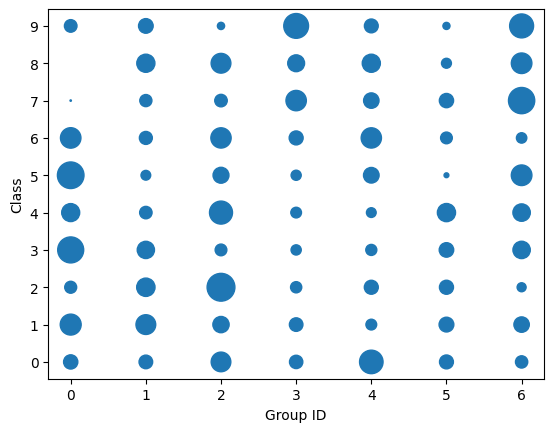

NameError: name 'networks' is not defined

In [23]:
# X_sel = X[np.argmin(F[:,2])]
X_sel = X

class_dist = np.asarray(group_distribution(main_label_vectors, X_sel))

x = np.array(np.meshgrid(np.arange(len(np.unique(X_sel))),np.arange(NO_CLASSES))).T.reshape(-1,2)[:,0]
y = np.array(np.meshgrid(np.arange(len(np.unique(X_sel))),np.arange(NO_CLASSES))).T.reshape(-1,2)[:,1]
s = class_dist.reshape(1,-1)[0]
s = ((s - np.amin(s))/(np.amax(s) - np.amin(s))*400).astype("int")

plt.scatter(x,y,s)
plt.yticks(np.arange(10))

plt.xlabel("Group ID")
plt.ylabel("Class")
plt.show()

h = np.asarray(network_diff(networks, X_sel))
fed_duration = []
for group_id in range(NO_GROUPS):
    model_size = sizes_by_block[group_id]
    group_networks = networks[np.array(X_sel) == group_id]
    bn_bw = np.amin(group_networks)
    dur = model_size / (bn_bw / 8 / 1_000_000)
    fed_duration.append(dur)
h = fed_duration
plt.bar(np.arange(len(h)), h)
# plt.ylim(5900,6000)
plt.show()

# for group_id in range(NO_GROUPS):
#     model_size = sizes_by_block[group_id]
#     group_networks = networks[np.array(X_sel) == group_id]
#     print(group_networks/1_000_000)

In [16]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 700x500 with 0 Axes>

ValueError: s must be a scalar, or float array-like with the same size as x and y

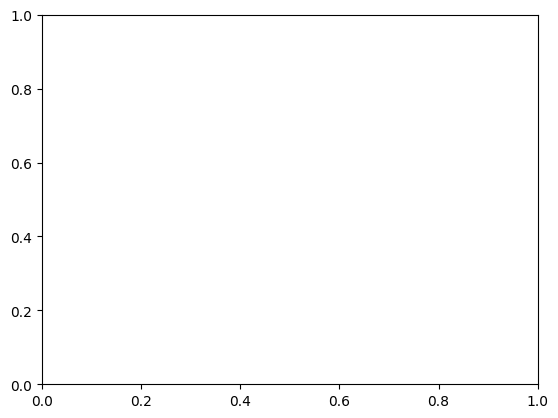

In [20]:
if len(X) < 14: X_sel = X[0]
else: X_sel = X
# X_sel = X[0]

for X_sel in np.unique(X, axis=0):

    class_dist = np.asarray(group_distribution(main_label_vectors, X_sel))

    x = np.array(np.meshgrid(np.arange(len(np.unique(X_sel))),np.arange(NO_CLASSES))).T.reshape(-1,2)[:,0]
    y = np.array(np.meshgrid(np.arange(len(np.unique(X_sel))),np.arange(NO_CLASSES))).T.reshape(-1,2)[:,1]
    s = class_dist.reshape(1,-1)[0]
    s = ((s - np.amin(s))/(np.amax(s) - np.amin(s))*400).astype("int")

    plt.scatter(x,y,s)
    plt.yticks(np.arange(10))
    plt.show()

[0 4 2 6 4 6 5 3 1 4 2 5 6 0 5 0 1 3 3 4 2 3 2 1 0 4 1 3 3 6 0 1 5 4 5 1 2
 2 6 3 0 0 2 6 1 4 5 1 0 6 2 5 4 6 3 5]
56


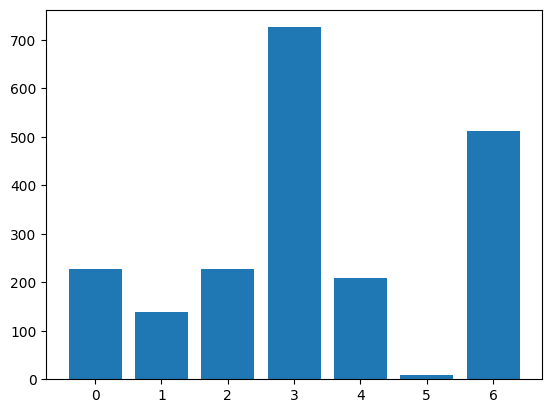

[0 4 2 6 4 6 5 3 1 4 2 5 6 0 5 0 1 6 1 4 2 3 2 1 0 4 3 3 2 6 0 1 5 4 5 1 1
 2 6 3 3 0 2 3 0 4 5 1 0 6 2 5 4 6 3 5]
56


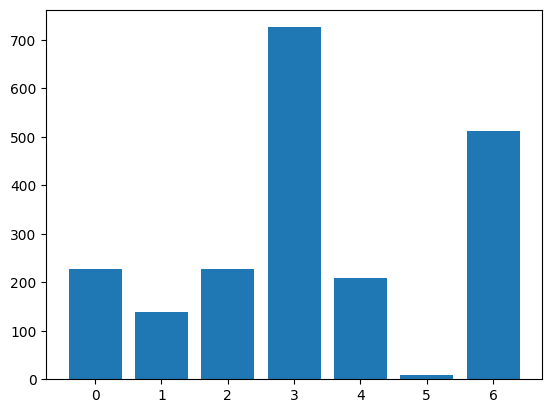

[4 5 3 3 5 4 0 2 3 2 0 2 5 3 2 1 5 1 4 1 6 0 2 6 0 4 3 2 1 5 6 2 3 0 4 1 0
 0 4 6 5 1 6 3 3 0 1 6 5 6 5 1 4 4 2 6]
56


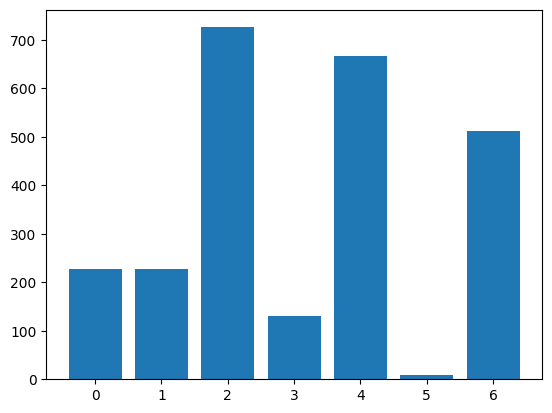

[6 2 1 4 6 5 3 2 4 0 6 2 6 4 0 3 4 6 5 2 0 0 3 0 1 4 4 0 5 2 2 1 3 5 6 3 6
 4 1 3 2 3 0 5 5 6 3 5 1 1 1 0 2 5 1 4]
56


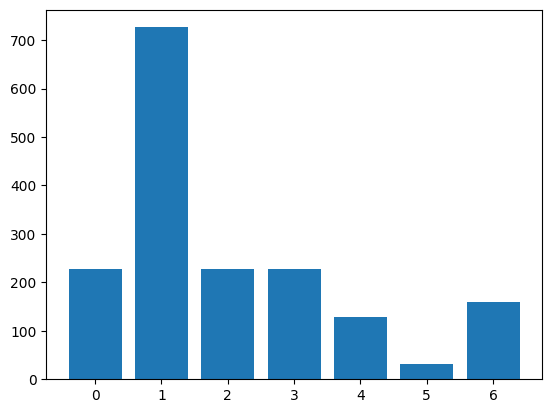

In [58]:

for X_sel in np.unique(X, axis=0):
    print(X_sel)
    print(len(X_sel))

    try:

        h = np.asarray(network_diff(networks, X_sel))

        fed_duration = []
        for group_id in range(NO_GROUPS):
            model_size = sizes_by_block[group_id]
            group_networks = networks[np.array(X_sel) == group_id]
            bn_bw = np.amin(group_networks)
            dur = model_size / (bn_bw / 8 / 1_000_000)
            fed_duration.append(dur)
        h = fed_duration
        plt.bar(np.arange(len(h)), h)
        # plt.ylim(5900,6000)
        plt.show()
    except:
        pass

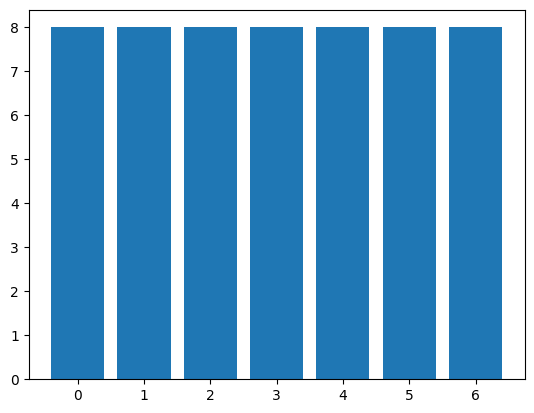

In [284]:
h = np.unique(X_sel, return_counts=True)[1]
plt.bar(np.arange(len(h)), h)
plt.show()

In [437]:
for X_sel in np.unique(X, axis=0):
    for group_id in range(NO_GROUPS):
        model_size = sizes_by_block[group_id]
        group_networks = networks[np.array(X_sel) == group_id]
        print(group_networks/1_000_000)
    print("================================")

[ 9.  9. 45. 45.  9. 14. 15. 45.]
[15. 12. 45. 15. 15. 45. 12. 15.]
[12.  14.  15.  15.   2.5 45.  15.   2.5]
[11.  15.  15.  14.  11.   2.5 30.   9. ]
[ 9. 12. 45. 15. 15. 30. 11. 15.]
[ 9. 14.  9. 45. 15. 30.  9. 30.]
[ 9.  15.   2.5  9.  11.  15.   9.   9. ]
[ 9. 45. 45.  9. 14. 15. 45. 11.]
[ 9.  14.  45.  15.  15.   2.5 45.  12. ]
[12. 15. 11. 15. 15. 15. 30. 15.]
[12.  14.  11.  45.   2.5 30.   9.  30. ]
[15. 12. 45. 15. 15. 15. 30. 15.]
[ 9.  14.   9.  45.  15.   9.   9.   2.5]
[ 9.  15.  15.   9.   2.5  9.  11.   9. ]
[ 9. 14. 45. 15. 14. 15. 45. 11.]
[12.  45.  45.  15.  15.  45.  12.   2.5]
[12.   9.  15.  15.   2.5 45.  15.  15. ]
[15.   9.  14.  11.   2.5 30.  30.   9. ]
[ 9. 11. 15. 12. 45. 15. 15. 15.]
[ 9.  9. 45. 15. 11. 30.  9. 30.]
[15.   2.5  9.  14.   9.  15.   9.   9. ]


In [76]:
baseline_dict

{9.623975: [2500000,
  2500000,
  2500000,
  2500000,
  9000000,
  9000000,
  9000000,
  9000000],
 160.160487: [9000000,
  9000000,
  9000000,
  9000000,
  9000000,
  9000000,
  9000000,
  9000000],
 208.148775: [11000000,
  11000000,
  11000000,
  11000000,
  12000000,
  12000000,
  12000000,
  12000000],
 226.930983: [14000000,
  14000000,
  14000000,
  14000000,
  15000000,
  15000000,
  15000000,
  15000000],
 226.949479: [15000000,
  15000000,
  15000000,
  15000000,
  15000000,
  15000000,
  15000000,
  15000000],
 227.060071: [15000000,
  15000000,
  15000000,
  15000000,
  30000000,
  30000000,
  30000000,
  30000000],
 227.205799: [45000000,
  45000000,
  45000000,
  45000000,
  45000000,
  45000000,
  45000000,
  45000000]}